# GCC218 - Algoritmos em Grafos
## Desafio - ShopMais

`Breno Oliveira - 201520629`

`Guilherme Baviera - 201420521`

`Guilherme Henrique Haddad - 201520615`



## Fase 0

#### 1 - Leitura do arquivo de entrada
#### 2 - Sumarização
#### 3 - Visualização dos dados

In [1]:
with open('__InstanciaMayron.txt') as file:
    N = int(file.readline())
    R = int(file.readline())
    K = int(file.readline())
    H = int(file.readline())
    centros_distribuicao = [file.readline().split() for i in range(R)]
    clientes = ["".join([file.readline(), "-1"]).split() for i in range(N-R)]
    vehicles = [file.readline().split(' ') for i in range(K)]
    

#### Exibição Inicial

Nesse bloco, serão mostrados os Centro de Distribuição (vermelhos) e o Cliente (azul).

Isto ajuda a elucidar a distribuição dos clientes para esse problema.

In [2]:
from matplotlib import pyplot as plt
import random
#para todos os centros:
plt.scatter([float(x) for x,_,_,_,_ in centros_distribuicao], [float(y) for _,y,_,_,_ in centros_distribuicao], color='red')
#para todos os clientes
plt.scatter([float(x) for x,_,_,_,_,_ in clientes], [float(y) for _,y,_,_,_,_ in clientes], color='blue')


#axis = Define os limites do plano. Nesse caso é definido como igual tanto para min,máx dos eixos X e Y.
plt.axis('equal')

#xlabel ou xlabel = Define o "nome" de cada eixo, nesse caso mantemos como X e Y
plt.xlabel("x")
plt.ylabel("y")
#show = exibe a plotagem dos pontos no plano cartesiano
plt.show()

<Figure size 640x480 with 1 Axes>

# Fase 1

## Primeira Abordagem
Para cada `cliente (vértice)` calcule o `centro de distribuição` mais próximo.

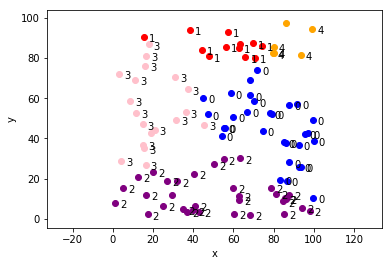

In [3]:
import sys
import math

colors = ['blue', 'red', 'purple', 'pink', 'orange']

#Fórmula para cálculo de distância Euclidiana entre dois pontos no plano cartesiano
def euclidian_distance(x1, y1, x2, y2):
    return math.sqrt((x2-x1)**2+(y2-y1)**2)


for i,[point_x,point_y,_,_,_,_] in enumerate(clientes):
    menor = sys.maxsize
    for j,[centros_distribuicao_x,centros_distribuicao_y,_,_,_] in enumerate(centros_distribuicao):
        if euclidian_distance(float(point_x), float(point_y), float(centros_distribuicao_x), float(centros_distribuicao_y)) < menor:
            menor = euclidian_distance(float(point_x), float(point_y), float(centros_distribuicao_x), float(centros_distribuicao_y))
            clientes[i][5] = j


for idx,[x,y,_,_,_] in enumerate(centros_distribuicao):
    plt.scatter(float(x), float(y), color=colors[idx])

for x,y,_,_,_,dist in clientes:
    plt.scatter(float(x), float(y), color=colors[dist])
    
for p in clientes:
    plt.annotate(p[5], xy=(float(p[0]),float(p[1])), xytext=(5,-5), textcoords='offset points')
    
plt.axis('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## Segunda Abordagem

Utilizar o `diagrama de Voronoi` para `clusterizar` as regiões

Mais informações, leia: https://pt.wikipedia.org/wiki/Diagrama_de_Voronoy

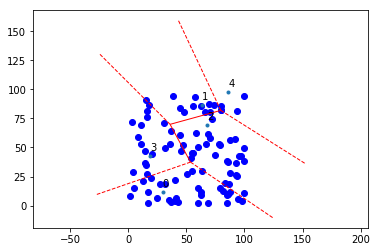

In [4]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import numpy as np

vor = Voronoi([(float(x),float(y)) for x,y,_,_,_ in centros_distribuicao])
voronoi_plot_2d(vor, line_colors='red', show_vertices=False)

for idx,d in enumerate(centros_distribuicao):
    plt.annotate(vor.point_region[idx], xy=(float(d[0]),float(d[1])), xytext=(0,5), textcoords='offset points')
    
for x,y,_,_,_,_ in clientes:
    plt.scatter(float(x), float(y), color='blue')
plt.axis('equal')

plt.show()

point = Point(0, 0)
polygon = Polygon([vor.vertices[i] for i in vor.regions[5] if not i == '-1'])

## Heurística para transformação para `regiões finitas`

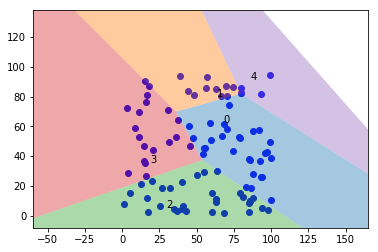

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon

def voronoi_with_finite_polygons(vor):
    """
    
    """

    new_regions = []
    # Vértices do diagrama de voronoi
    new_vertices = vor.vertices.tolist()
    # Ponto médio entre os centros de distribuição
    center = vor.points.mean(axis=0)
    
    # Atualiza raio que dará a posição do vértice, d'antes infinito, no novo polígono
    radius = vor.points.ptp().max()*2

    # Estrutura para armazenar os vértices de voronoi que se cruza ao sair de um ponto de distribuição para um outro qualquer de região vizinha
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
        
    # Cálculo das regiões infinitas
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        
        # Se nenhum dos pontos da região possui um vértice no infinito
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]

        # Vértices que não estão no infinito
        new_region = [v for v in vertices if v >= 0]
        
        for idx, [p2, v1, v2] in enumerate(ridges):
            #print(p1, p2, v1, v2)
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # Ridge finita que já consta na região
                continue

            # Computa os pontos infinitos na região
            t = vor.points[p2] - vor.points[p1] # tangente
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            # Atualiza all_ridges com os novos vértices calculados
            v1 = len(new_vertices)
            ridges[idx] = [p2, v1, v2]
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        
        # Ordena as regiões de forma anti-horária
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices), all_ridges

dists = np.array([[float(x),float(y)] for x,y,_,_,_ in centros_distribuicao])

# Cria diagrama de Voronoi
vor = Voronoi(dists)

# Transforma pontos infinitos em finitos
regions, vertices, all_ridges = voronoi_with_finite_polygons(vor)

# TODO: pegar valor max e min dos pontos de entrega e não dos pontos de distribuição
min_x = vor.min_bound[0] - 1000
max_x = vor.max_bound[0] + 1000
min_y = vor.min_bound[1] - 1000
max_y = vor.max_bound[1] + 1000

mins = np.tile((min_x, min_y), (vertices.shape[0], 1))
bounded_vertices = np.max((vertices, mins), axis=0)
maxs = np.tile((max_x, max_y), (vertices.shape[0], 1))
bounded_vertices = np.min((bounded_vertices, maxs), axis=0)

# Polígono geral do gráfico
box = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

new_regions = []

for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    polygon = [p for p in poly.exterior.coords]
    new_regions.append(poly)

    plt.fill(*zip(*polygon), alpha=0.4)

new_points = []
# Plota os pontos de entrega
for x,y,_,_,_,_ in clientes:
    plt.scatter(float(x), float(y), color='blue')
    for idx,region in enumerate(new_regions):
        if region.contains(Point(float(x), float(y))):
            # Imprime índice da região do ponto
            new_points.append([x,y,idx])
            #print(idx)


# Plota os indices das regiões
for idx,[x,y] in enumerate(dists):
    plt.annotate(idx, xy=(x,y), xytext=(0,-10), textcoords='offset points')

plt.axis('equal')
plt.xlim(vor.min_bound[0] - 20.1, vor.max_bound[0] + 20.1)
plt.ylim(vor.min_bound[1] - 20.1, vor.max_bound[1] + 40.1)

plt.show()

# `TODO`

## Heurística para melhoramento das divisões das regiões

A ideia utilizada:

1. Ordenar as regiões, de forma decrescente, de acordo com a quantidade de pontos de entrega contidos nas mesmas.

2. As regiões com mais pontos irão _doar_ os pontos mais próximos de outra região com menos pontos

    2.1 Para isso, calculamos o ponto mais proximo da ridge entre duas regiões
    
    2.2 Calculamos em qual posição do polígono este ponto será inserido
    
    2.3 Atualiza as duas regiões (polígonos) com o novo vértice


# Resultado da Fase 1

## Clientes

Após a leitura e preparação dos dados importados do `.txt` da entrada do problema
é instanciado uma lista de objetos do tipo Cliente.           

In [6]:
from cliente import Cliente

lista_de_clientes = []

for idx, point in enumerate(clientes):
    coordernadas = []
    coordernadas.append(point[0])
    coordernadas.append(point[1])
    volume = float(point[2])
    preco_mercadoria = float(point[3])
    qtd_pacotes = float(point[4])
    regiao = point[5]
    
    #Criada lista de Objetos do Tipo CLIENTE
    lista_de_clientes.append(Cliente(coordernadas, volume, preco_mercadoria, qtd_pacotes, regiao, idx))

In [7]:
#Feita uma conferência dentre todos os clientes quais estão em quais regiões.
#O somatório é salvo dentro de uma lista que vai de 0 a 4 (qtd de centros)
clientes_de_cada_centro = list()
for idx in range(0, 4):
    x=0
    clientes_do_centro = []
    for cliente in lista_de_clientes:
        if cliente.get_centro() == idx:
            clientes_do_centro.append(cliente)
            x+=1
    clientes_de_cada_centro.append(clientes_do_centro)

#Verifica qual cliente pertence a qual centro, após isso é inserida a lista criada acima com os todos os vertices do centro
#A partir dessa informação é calculada a distancia de cada cliente para todos os demais, gerando assim a informação de um "grafo completo", no qual as arestas são as distâncias encontradas
for idx in range(0, 4):
    for cliente in lista_de_clientes:
        if cliente.get_centro() == idx:
            cliente.set_distancia_para_vizinhos(clientes_de_cada_centro[idx])

In [8]:
#Sobrecarga da função __str__ para exibir os dados para visualização no Notebook

[print(cliente) for cliente in lista_de_clientes];
#Obs: adicionado ; após essa linha, pois no Jupyter imprime 2x quando ele não está presente

Cliente: 0	 Centro de Atendimento: 2	 Volume Pedido: 0.09396032321647135	 Qtd Pacotes: 11.0
Cliente: 1	 Centro de Atendimento: 0	 Volume Pedido: 0.14318163064767153	 Qtd Pacotes: 4.0
Cliente: 2	 Centro de Atendimento: 0	 Volume Pedido: 0.14531523926292828	 Qtd Pacotes: 1.0
Cliente: 3	 Centro de Atendimento: 1	 Volume Pedido: 0.09319911547727258	 Qtd Pacotes: 5.0
Cliente: 4	 Centro de Atendimento: 4	 Volume Pedido: 0.15527889771935796	 Qtd Pacotes: 8.0
Cliente: 5	 Centro de Atendimento: 2	 Volume Pedido: 0.1271336952835011	 Qtd Pacotes: 11.0
Cliente: 6	 Centro de Atendimento: 3	 Volume Pedido: 0.17914883174053134	 Qtd Pacotes: 7.0
Cliente: 7	 Centro de Atendimento: 2	 Volume Pedido: 0.173862977126582	 Qtd Pacotes: 1.0
Cliente: 8	 Centro de Atendimento: 2	 Volume Pedido: 0.04193218751879426	 Qtd Pacotes: 6.0
Cliente: 9	 Centro de Atendimento: 2	 Volume Pedido: 0.19018530991657864	 Qtd Pacotes: 2.0
Cliente: 10	 Centro de Atendimento: 2	 Volume Pedido: 0.13643131127088579	 Qtd Pacotes: 2.0

## Centros

In [9]:
from centro import Centro

#Instancia os centros de distribuicao
lista_de_centros = []

for idx, center in enumerate(centros_distribuicao):
    coordenadas = []
    coordenadas.append(center[0])
    coordenadas.append(center[1])
    clientes_do_centro = []
    #  Pega todos os clientes que pertencem ao centro em questao
    clientes_do_centro = [cliente for cliente in lista_de_clientes if cliente.get_centro() == idx]
    label = idx

    lista_de_centros.append(Centro(coordenadas, clientes_do_centro, label))

In [10]:
#Sobrecarga da função __str__ para exibir os dados para visualização no Notebook

[print(centro) for centro in lista_de_centros];
#Obs: adicionado ; após essa linha, pois no Jupyter imprime 2x quando ele não está presente

Centro: 0	 Qtd de Cliente: 29	 Volume Total: 2.954483747403371
Centro: 1	 Qtd de Cliente: 11	 Volume Total: 0.9057871343845953
Centro: 2	 Qtd de Cliente: 32	 Volume Total: 3.38871939654598
Centro: 3	 Qtd de Cliente: 18	 Volume Total: 1.704229181965136
Centro: 4	 Qtd de Cliente: 5	 Volume Total: 0.5930803855118546


# Veículos

In [11]:
from veiculo import Veiculo

lista_de_veiculos = []

for idx, veiculo in enumerate(vehicles):

    volume_maximo_suportado = float(veiculo[0])
    valor_maximo_suportado = float(veiculo[1])
    velocidade_inicial_final = float(veiculo[3])
    velocidade_normal = float(veiculo[4])
    tempo_carga = float(veiculo[5])
    tempo_descarga = float(veiculo[6])
    custo_medio_hora = float(veiculo[7])
    custo_medio_km = float(veiculo[8])
    custo_fixo_diario = float(veiculo[9])

    quantidade_veiculos_disponiveis = int(veiculo[2]) #Quantidade de veiculo disponivel de cada tipo

    tipos = {0 : 'Van',
           1 : 'Mini-Van',
           2 : 'Comum',
           3 : 'Motocicleta',
           4 : 'Van terceirizada'}

    tipo_veiculo = tipos.get(idx)

    # Para a quantidade de veiculo de cada tipo, cria os respectivos veiculos
    for veiculos in range(quantidade_veiculos_disponiveis):
        lista_de_veiculos.append(Veiculo(volume_maximo_suportado, valor_maximo_suportado,
                                               velocidade_inicial_final, velocidade_normal,
                                                tempo_carga, tempo_descarga, custo_medio_hora,
                                                custo_medio_km, custo_fixo_diario, tipo_veiculo))

In [12]:
#Sobrecarga da função __str__ para exibir os dados para visualização no Notebook

[print(veiculo) for veiculo in lista_de_veiculos];
#Obs: adicionado ; após essa linha, pois no Jupyter imprime 2x quando ele não está presente

Veículo: Van
	Custo dia: 115.0	Custo km: 4.0	Custo hora: 34.0
	Vol. Máximo: 8.0	Valor. Máximo: 71815.0
	Vel. Ini/Fin: 20.0	Vel. Normal: 34.0
Veículo: Van
	Custo dia: 115.0	Custo km: 4.0	Custo hora: 34.0
	Vol. Máximo: 8.0	Valor. Máximo: 71815.0
	Vel. Ini/Fin: 20.0	Vel. Normal: 34.0
Veículo: Van
	Custo dia: 115.0	Custo km: 4.0	Custo hora: 34.0
	Vol. Máximo: 8.0	Valor. Máximo: 71815.0
	Vel. Ini/Fin: 20.0	Vel. Normal: 34.0
Veículo: Van
	Custo dia: 115.0	Custo km: 4.0	Custo hora: 34.0
	Vol. Máximo: 8.0	Valor. Máximo: 71815.0
	Vel. Ini/Fin: 20.0	Vel. Normal: 34.0
Veículo: Van
	Custo dia: 115.0	Custo km: 4.0	Custo hora: 34.0
	Vol. Máximo: 8.0	Valor. Máximo: 71815.0
	Vel. Ini/Fin: 20.0	Vel. Normal: 34.0
Veículo: Van
	Custo dia: 115.0	Custo km: 4.0	Custo hora: 34.0
	Vol. Máximo: 8.0	Valor. Máximo: 71815.0
	Vel. Ini/Fin: 20.0	Vel. Normal: 34.0
Veículo: Van
	Custo dia: 115.0	Custo km: 4.0	Custo hora: 34.0
	Vol. Máximo: 8.0	Valor. Máximo: 71815.0
	Vel. Ini/Fin: 20.0	Vel. Normal: 34.0
Veículo: Van


# Conclusão Fase 1

Pelas nossas análises, os pontos que levamos em conta para efetuar a `alocação ideal` dos `veiculos` para cada `cluster (Centro de Distribuição)` seriam o `Volume Máximo Suportado` e o `Valor Máximo Suportado` por cada veiculo em relação ao `Valor Total` e o `Volume Total` de todos os clientes que compõe a cada Centro. 

Sendo assim, a ideia é tentar distribuir os veículos nos centros de modo a nunca faltar veiculos para cada centro e chegar o mais próximo do mínimo de veículos por centro. 

Porém pelas instâncias geradas pelo gerador, notamos que teríamos uma enorme folga em relação as capacidades dos veículos com a demanda total de cada centro (total dos clientes), levando em conta o volume máximo e o valor máximo de cada cliente. 

`Portanto, decidimos dividir igualmente os veiculos para os centros e, ao realizar as operações de entrega dos volumes para os clientes, utilizar dos veiculos alocados em cada centro, do mais barato para o mais caro até suprir a demanda.`


## Fase 2

#### 1 - Roteirização